# Содержание
***

1. [Перезентация](#presentation)
2. [Дашборд](#dash)
3. [Описание проекта](#specification_id)
4. [Изучение и предобработка данных](#info_id)
5. [Исследовательский анализ данных](#eda)
    1. [Распределение выручки и количества товаров](#stat_info)
    2. [Структура заказов пользователей](#order_structure)
    3. [Динамика объема продаж и среднего чека](#dynamics)
    4. [Оценка пользовательской активности](#user_activity)
6. [Категоризация товара](#category)
7. [Сегментация пользователей по профилю потребления](#segmentation)
8. [Анализ сегментов пользователей](#segment_analysis)
9. [Проверка гипотезы о различии среднего чека между группами пользователей](#hypothesis_testing)
10. [Общий вывод](#fin)
11. [Приложение](#application)


<a id='presentation'></a>
## Презентация
***
[Сегментация пользователей по профилю потребления](https://drive.google.com/file/d/1vUvZ12GWFF8f8RsnrzugLO7nbFvtZyxE/view?usp=sharing)

<a id='dash'></a>
## Дашборд
***
[Динамика покупок интернет-магазина "Пока все еще тут"](#https://public.tableau.com/app/profile/evgeny2545/viz/dash_purchase_dynamics/Dashboard1?publish=yes)

<a id='info_id'></a>
## Изучение и предобработка данных
***
**To do:**
1. Импортировать необходимые библиотеки;
2. Прочитать данные;
3. Проверить:
    - пропуски;
    - дубликаты;
    - соответствие значение типам данных;
4. Выполнить предобработку данных;    
5. Сделать вывод.

Импортируем библиотеки

In [ ]:
# Основные библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import levene
from scipy.cluster.hierarchy import dendrogram, linkage

# Библиотеки визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Библиотеки для прогнозирования
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Дополнительные библиотеки
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os
import re

# Отклчючение предупреждений
import warnings
warnings.filterwarnings('ignore')

#  Настройки
pd.set_option('display.max_rows', 500)

In [ ]:
df.sample(5, random_state=0)

,date,customer_id,order_id,product,quantity,price
3302,2019042913,603e92a4-fc7f-4203-9ca5-103da5b008ac,14705,Рассада Остеоспермум крупноцветковый Purple ма...,1,127.0
4315,2019060216,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0
1580,2019012314,8fa1ee5d-7955-4ad6-8ce0-fd27033e991a,69944,Емкость для соуса с ложкой PASABAHCE 200 мл OT...,15,101.0
4086,2019052818,63d48b37-11ca-46ec-b858-26cc165f7629,14825,Петуния простая рассада однолетних цветов в ка...,2,128.0
3896,2019051718,b6095dc9-1580-4d1f-8ba3-a554a8dab3bd,14789,Рассада Дыни сорт Колхозница горшок 9х9 см P-9,4,38.0


Данные успешно загружены.  
С названиями полей тоже все отлично: в нижнем регистре, наименования с более 1 словом разделены нижним подчеркиванием *(snake_case)*.  
Посмотрим на общую информацию о датасете, проверим на пропуски и дубликаты.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


1. Имеем 6737 наблюдений;
2. Пропусков нет;
3. Тип данных для поля `date` некорректный, далее переведем его в `datetime`.

In [ ]:
print('\033[1m' + 'Количество дубликатов в датасете: ' + '\033[0m' + '{}'.format(df.duplicated().sum()))
print('\033[1m' + 'Доля дубликатов: '  + '\033[0m' + '{:.0%}'.format(df.duplicated().mean()))

Количество дубликатов в датасете: 0
Доля дубликатов: 0%


Дубликатов тоже нет. Отлично!  
Посотрим на основные статистические показатели наших данных.

In [ ]:
df.describe()

,date,order_id,quantity,price
count,6.737000e+03,6737.000000,6737.000000,6737.000000
mean,2.018855e+09,43128.948345,2.501559,462.028499
std,3.855185e+05,27899.414662,15.266478,871.296064
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019020e+09,14827.000000,1.000000,101.000000
50%,2.019050e+09,68503.000000,1.000000,135.000000
75%,2.019061e+09,70504.000000,1.000000,398.000000
max,2.019103e+09,73164.000000,1000.000000,14917.000000


**Средняя цена товара** в 3.5 раза превышает значение медианы, 462 и 135 соответственно, со стандартным отклоненением 871. То есть наши клиенты покупают как дорогой товар, так и дешевый.  
**Среднее количество покупок** также завышено и составляет 2.5 при медиане 1.  Можно предположить, что клиенты деляться на тех кто закупаем оптом и розничных покупалетей.  
Более детально узнаем на этапе исследовательского анализа. 

Приведем тип данных поля `date` в нежуный формат `datetime`

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [ ]:
print('\033[1m' + 'Начало исследуемого периода: ' + '\033[0m' + '{}'.format(df['date'].min()))
print('\033[1m' + 'Конец исследуемого периода: ' + '\033[0m' + '{}'.format(df['date'].max()))

Начало исследуемого периода: 2018-10-01 00:00:00
Конец исследуемого периода: 2019-10-31 16:00:00


Итого, мы имеем данные за 1 год и 1 месяц: с начало октября 2018 г. по конец октября 2019 г.

### Вывод
***
Мы изучили данные и выполнили их предобраотку в части изменения типа данных поля `date`. Итого по этапу проверки:
1. Всего 6737 наблюдений;
1. Пропущенных значений и дубликатов нет;
2. Имеем завышенные средние по полям "Цена товара" и "Количество товара". Детальный анализ выбросов запланирован в следующих этапах анализа.
3. Исследуемый период составляет 1 год и 1 месяц.
 

<a id='eda'></a>
## Исследовательский анализ данных
***
**To do:**
1. Оценить распределения выручки и количества товаров;
2. Оценить структуру заказов пользователей:
    - Распределение количества заказов на 1 пользователя;
    - Распределение среднего количества товара в заказе;
    - Распределение количества позиций в заказах *(ассортимент)*.  
2. Изучить динамику изменения среднего чека и объема продаж;
3. Сделать оценку пользовательской активности:
4. Сделать выводы.

<a id='stat_info'></a>
### Оценка распределения выручки и количества товаров
***

**Распределение выручки. Анализ аномалий.**

Прежде чем начинать исследование, выразим дату заказа в формате: даты, недели и месяц.

In [ ]:
df['order_date'] = df['date'].dt.date
df['week_of_order'] = df['date'].astype('datetime64[W]')
df['month_of_order'] = df['date'].astype('datetime64[M]')
df.head()

,date,customer_id,order_id,product,quantity,price,order_date,week_of_order,month_of_order
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,2018-09-27,2018-10-01
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,2018-09-27,2018-10-01
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018-09-27,2018-10-01
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,2018-09-27,2018-10-01
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,2018-09-27,2018-10-01


Определим выручку.

In [ ]:
df['revenue'] = df['quantity'] * df['price']

Напишем фунцию, которая будем показывать распределения данных, а также выводить основную статистику.

In [ ]:
def statistics_info (data, column,value):
    '''
    Функция для визулизации распределения данных по заказам пользователя
    На вход принимается 3 параметра:
    первым указывается датасет
    вторым указывается поле из датасета
    третьим указывается целое число, значение по которому будет делаться срез

    Дополнительно выводится описательная статистика и 95,99 перцентили
    ''' 
    # Создаем фигуру
    plt.figure(figsize=(12,5))
    plt.suptitle('Распределение признака: ' + column, fontsize=15)

    # Отображаем общий график распределения признака
    plt.subplot(121)
    plt.hist(data[column], bins=25, color='#0A1D37')
    plt.title('Общее распределение', fontsize=12)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
    plt.xticks(rotation=20)
    plt.grid()

    # Отображаем график распределения признака с ограничением по выводу значений
    # С помощью параметра range подбираем необходимый диапазон, чтобы график был информативный
    plt.subplot(122)
    plt.hist(data[column], bins=25, range=(0, value), color='#0A1D37')
    plt.title('Распределение с оганичением значений', fontsize=12)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
    plt.grid()
    
    plt.show()
 
    print('\033[1m' + 'Описательная статистика' + '\033[0m')
    print('---------------------------------------------------')
    print(data[column].describe())
    print('')
    print('\033[1m' + '95-й и 99-й перцентили соответственно' + '\033[0m')
    print('---------------------------------------------------')
    print(np.percentile(data[column], [95, 99]))


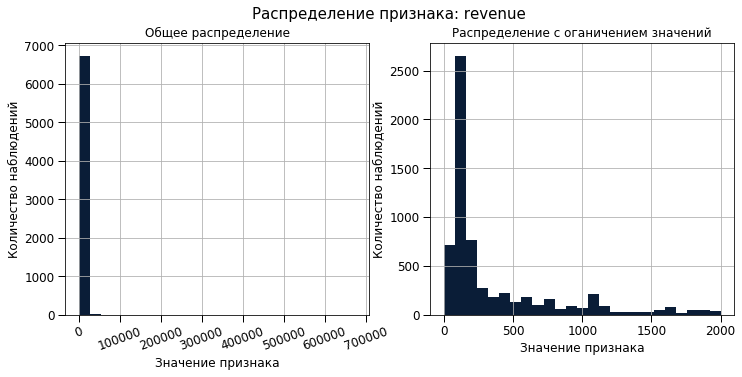

Описательная статистика
---------------------------------------------------
count      6737.000000
mean        720.094998
std        8352.100591
min           9.000000
25%         120.000000
50%         162.000000
75%         600.000000
max      675000.000000
Name: revenue, dtype: float64

95-й и 99-й перцентили соответственно
---------------------------------------------------
[2624. 5594.]


In [ ]:
statistics_info(df, 'revenue', 2000)

**Наши данные очень вариативны:** среднее значение равное 720, со стандартным отклонеием в 8352. Завышенное среднее объясняется наличием больших выбросов.  
На втором графике мы видим распределение с учетом ограничения знечения от 0 до 2000. Можно сделать вывод о том, что наибольшая часть значения лежит  от 0 до 500. 5% наблюдений имеют выручку от 2624 и выше.

<a id='stat_info'></a>
**Распределение количества товаров в заказе. Анализ аномалий**

Построим график распределения количества товаров.

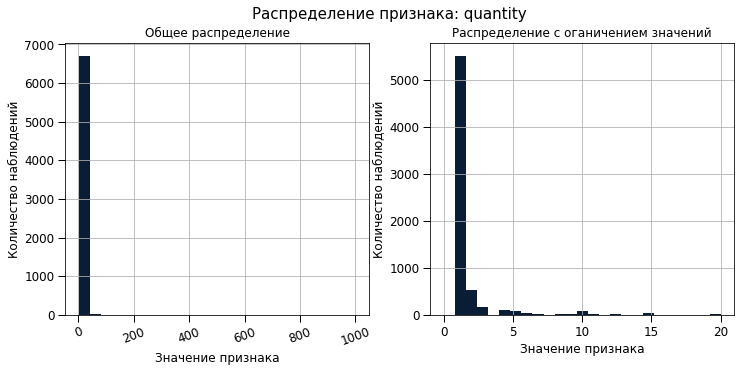

Описательная статистика
---------------------------------------------------
count    6737.000000
mean        2.501559
std        15.266478
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

95-й и 99-й перцентили соответственно
---------------------------------------------------
[ 6.   26.64]


In [ ]:
statistics_info(df, 'quantity', 20)

Типичный пользователь покупает товар в количестве 1 шт.   
От 6 и более штук покупают 5% пользователь.  

Удалим выбросы, границей будем считать 95 перцентиль

In [ ]:
# Удаление выбросов по выручке
df_filtered = df.loc[df['revenue'] < np.percentile(df['revenue'], [95]).item()]
df_filtered['revenue'].max()

2600.0

In [ ]:
# Удаление выбрасов по объему заказа
df_filtered = df.loc[df['quantity'] < np.percentile(df['quantity'], [95]).item()]
df_filtered['quantity'].max()

5

In [ ]:
df_filtered = df_filtered.reset_index()

In [ ]:
print('\033[1m' + 'Доля выбросов: ' + '\033[0m' + '{:.0%}'.format((len(df) - len(df_filtered))/len(df)))

Доля выбросов: 5%


Итого ушло 5 % данных по заказам.  
Приступим к изучению структуры покупок.

#### Вывод
***
На основе оценки распределения данных по выручке и количество товара в заказе мы можем сделать вывод:
1. **Типичная выручка равна 162**. В данных есть выбросы, которые завышают среднюю. Есть товары, которые приносят от 2600 у.е. и более, но  таких 5%
2. В среденем **пользователи покупают 1 шт. товара**, но есть те, которые покупают и больше. Так например более 6 шт.товара в 5% наблюдений.

**Проверка на уникальность пользователя в заказах и даты заказа**

Проверим, сколько у 1 заказа может быть уникальных дат.  
Полученные результаты сохраним в отдельный лист для очистки нашего датасета

In [ ]:
# Считаем количество уникальных дат по каждому заказу
orders_with_two_dates = df_filtered.groupby('order_id')['order_date'].nunique().reset_index()
orders_with_two_dates.columns = ['order_id', 'n_date']

In [ ]:
# Сохраняем те заказы, у которых больше или равно 2 даты
orders_with_two_dates = list(orders_with_two_dates[orders_with_two_dates['n_date'] >= 2] ['order_id'])
len(orders_with_two_dates)

168

Итого 168 кривых заказов.  
Можно предположить, следюущее:
- что это ошибка, которая возникла при выгрузке данных;
- или же это техническая ошибка записи данных в БД;
- или же это не ошибка а дата корректировки заказа.

В любом случае таки данные мы будем чистить для более корректного результата.  
Посмотрим на количество уникальных пользователей у заказа.


In [ ]:
# Считаем количество уникальных пользователей по каждому заказу
orders_with_two_users = df_filtered.groupby('order_id')['customer_id'].nunique().reset_index()
orders_with_two_users.columns = ['order_id', 'n_users']

In [ ]:
# Сохраняем те заказы, у которых больше или равно двух пользователей
orders_with_two_users = list(orders_with_two_users[orders_with_two_users['n_users'] >= 2] ['order_id'])
len(orders_with_two_users)

25

Таких получилось 25.  
Мы связыем это с технической ошибкой: сделать один заказ двум разным пользователям считаем невозможным.

Очистим датасет от выявленных заказов с отклонением

In [ ]:
df_filtered = df_filtered[~df_filtered['order_id'].isin(orders_with_two_dates)]
df_filtered = df_filtered[~df_filtered['order_id'].isin(orders_with_two_users)]
df_filtered = df_filtered.reset_index(drop=True)


In [ ]:
 print('\033[1m' + 'Доля некорректных заказов: ' + '\033[0m'+ '{:.0%}'.format((len(df) - len(df_filtered))/len(df)))

Доля некорректных заказов: 37%


Итого у нас получилось очень много кривых заказов.  
Необходимо написать запрос на инженерос с сообщением о проверки записи/выгрузки данных в/из БД.

<a id='order_structure'></a>
### Оценка структуры покупок пользователей
***

Сгруппируем заказы по пользователям, произведем расчеты:
- Количество заказов по каждому пользователю;
- Суммарное количество товаров;
- Cуммарную выручку;
- Количества уникальных позиций *(ассортимент)*.

In [ ]:
orders_вy_users = df_filtered.groupby('customer_id', as_index=False).agg({'order_id': pd.Series.nunique,
                                                                 'quantity':'sum',
                                                                 'revenue':'sum',
                                                                 'product': pd.Series.nunique})

In [ ]:
orders_вy_users.columns = ['customer_id', 'n_orders', 'total_quantity', 'total_revenue','n_products']
orders_вy_users.head()

,customer_id,n_orders,total_quantity,total_revenue,n_products
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,4,555.0,4
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,442.0,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2,914.0,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1649.0,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2,2324.0,1


Нам необходимо визуализировать 4 разных показателя, обратимся к уже готовой функции визуализаации распределения данных `statisitc_info`.

**Распределение количества заказов**

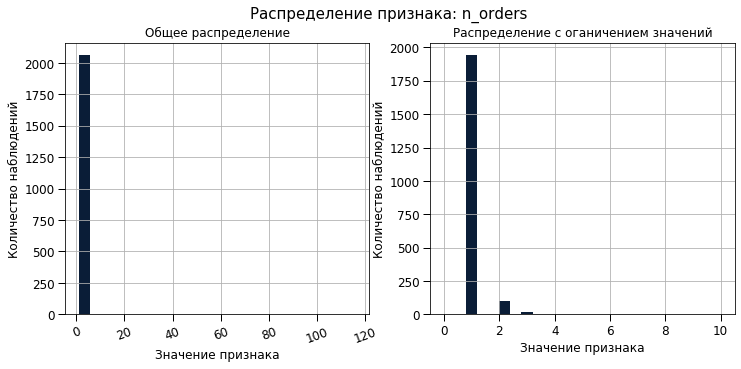

Описательная статистика
---------------------------------------------------
count    2063.000000
mean        1.146389
std         2.631764
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       116.000000
Name: n_orders, dtype: float64

95-й и 99-й перцентили соответственно
---------------------------------------------------
[2. 3.]


In [ ]:
statistics_info(orders_вy_users,'n_orders', 10)

Большинство пользователей совершают от 1 до 2 заказов.  
Есть единицы, которые совершают и больше:
- 5% пользователей совершают более 2 заказов.
- и всего 1% пользователей делают более 3 заказа; 

**Распределение объема всех покупок пользователей**

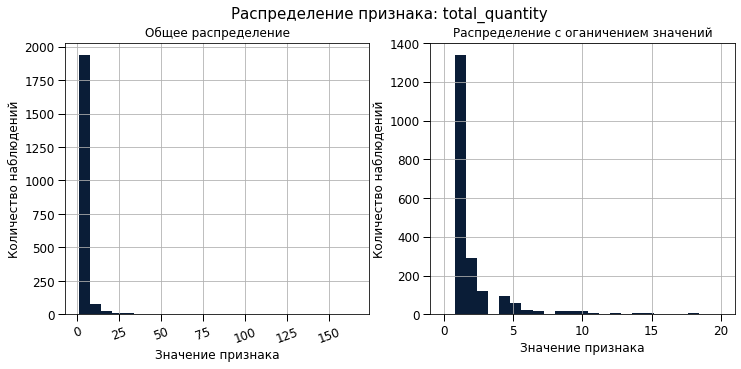

Описательная статистика
---------------------------------------------------
count    2063.000000
mean        2.645662
std         5.896948
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       166.000000
Name: total_quantity, dtype: float64

95-й и 99-й перцентили соответственно
---------------------------------------------------
[ 9. 26.]


In [ ]:
statistics_info(orders_вy_users, 'total_quantity', 20)

Больше половины пользователей покупают всего 1 шт. товара.  
Среднее находится близко к медиане, это хороший знак, выбросы по пользователям влияют незначительно.  
Больше 9 штук товаров в заказах имеют 5% пользователей.    
Посмотрим на выручку.


**Распределение суммарной выручки**

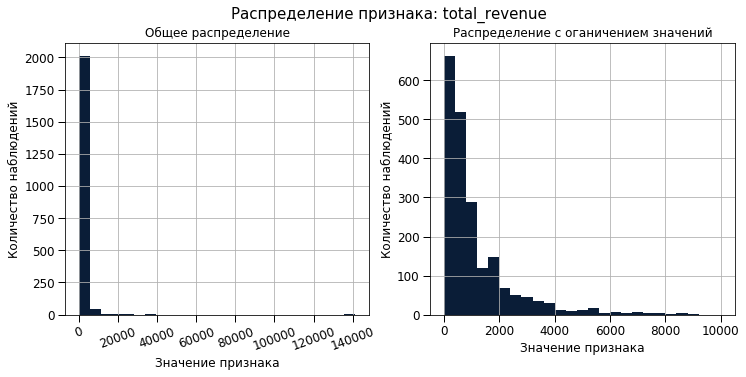

Описательная статистика
---------------------------------------------------
count      2063.000000
mean       1273.348522
std        3584.982877
min          14.000000
25%         291.000000
50%         674.000000
75%        1498.000000
max      141380.000000
Name: total_revenue, dtype: float64

95-й и 99-й перцентили соответственно
---------------------------------------------------
[3962.9  7713.46]


In [ ]:
statistics_info(orders_вy_users,'total_revenue', 10000)

Среднее значение выручки по пользователям в 2 раза выше медианы, и составляет 1273, со стандартным отклонением в 3584. Это говорит о том, что есть пользователли, которые тратят мало и есть те, которые тратят много и это разрыв очень большой. Очевидно наличие выбросов. Больше половины пользователей тратят 674 у.е.



**Распределение количества позиций в заказах *(ассортимент)***

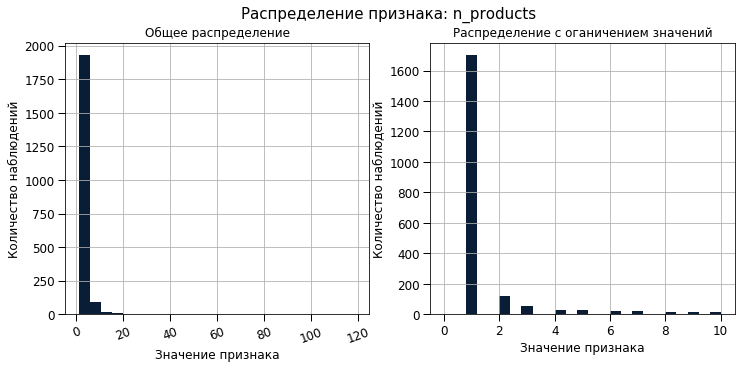

Описательная статистика
---------------------------------------------------
count    2063.000000
mean        1.945710
std         4.127686
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       119.000000
Name: n_products, dtype: float64

95-й и 99-й перцентили соответственно
---------------------------------------------------
[ 7. 17.]


In [ ]:
statistics_info(orders_вy_users,'n_products',10)

Преимущественно заказывают всего 1 позицию.  
Всего 5% пользователей имеют более 7 различного товара в заказах и 1% пользователей заказывают от 17 и выше.

#### Вывод
***
Итого по результатам исследования структуры покупок:
1. **Большинтсво пользователей совершают** 1 заказ, с 1 позицией в нем, с количеством товара равной 1 шт. Это портрет типичного покупателя нашего магазина. Больше половины таких пользователей тратят 674 у.е.

2. Мы также выделяем группу пользователей, которые отклоняются от стандратного покупателя. Как правило таки клиенты совершают более 2 заказов, с количеством товара от 9 шт. и выше, как правило с различным ассортиментом заказа: от 7 до 119 позиций.  Выручка с таких клиентов бывает от 3960 до 141380 у.е



**Произведем очистку данных по пользователям, откинем все данные, которые больше 95 перцентиля**

In [ ]:
orders_вy_users = orders_вy_users.loc[orders_вy_users['n_orders'] < np.percentile(orders_вy_users['n_orders'], [95]).item()]
orders_вy_users = orders_вy_users.loc[(orders_вy_users['total_quantity'] < np.percentile(orders_вy_users['total_quantity'], [95]).item())]
orders_вy_users = orders_вy_users.loc[(orders_вy_users['total_revenue'] < np.percentile(orders_вy_users['total_revenue'], [95]).item())]
orders_вy_users = orders_вy_users.reset_index(drop=True)

<a id='dynamics'></a>
### Динамика изменения среднего чека и объема продаж
***

Определим средний среднего чек и визуализирум динамику.  


In [ ]:
# Группируем данные по месяцу заказа, считаем общий объем товара
monthly_quantity = df_filtered.groupby('month_of_order')['quantity'].sum().reset_index()


In [ ]:
# Группируем данные по месяцу заказа, считаем сумму выручки
monthly_revenue = df_filtered.groupby('month_of_order').agg({'order_id': pd.Series.nunique,'revenue':'sum'}).reset_index()
monthly_revenue.columns = ['month_of_order', 'n_orders', 'total_revenue']

Для более информативной оценки изменения посчитаем срединй чек

In [ ]:
monthly_revenue['average_check'] = monthly_revenue['total_revenue'] / monthly_revenue['n_orders']

Построим графики

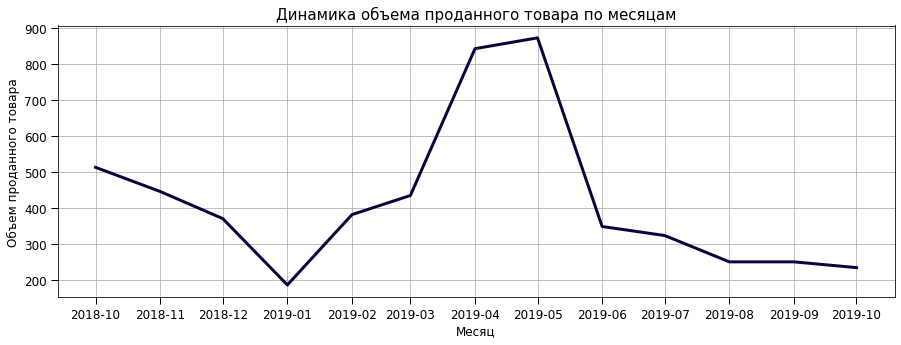

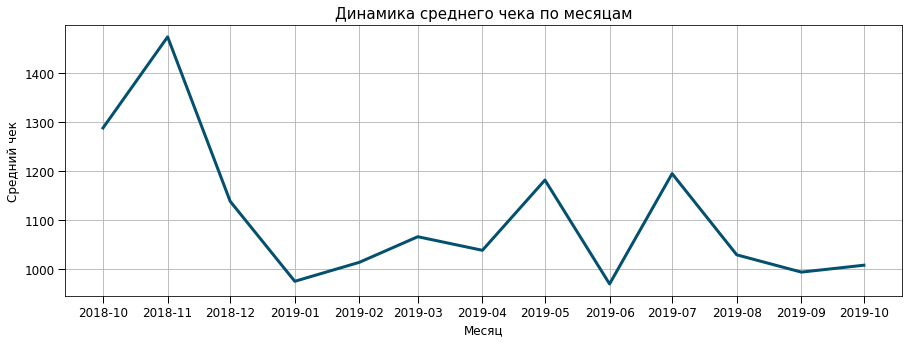

In [ ]:
# Создание фигуры
fig, axes1 = plt.subplots(figsize=(15, 5))

# График изменения объема проданного товара по месяцам
axes1.plot('month_of_order', 'quantity', data=monthly_quantity, color='#0A043C', linewidth = 3)
axes1.set_title('Динамика объема проданного товара по месяцам', fontsize=15)
axes1.set_xlabel('Месяц', fontsize = 12)
axes1.set_ylabel('Объем проданного товара', fontsize = 12)
axes1.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
# Вывод диапазона значений по оси X c интервалом в 1 месяц
fmt_year = mdates.MonthLocator(interval=1)
axes1.xaxis.set_major_locator(fmt_year)
axes1.grid()

# График изменения выручки по месяцам
fig, axes2 = plt.subplots(figsize=(15,5))
axes2.plot('month_of_order', 'average_check', data=monthly_revenue, color='#03506F', linewidth = 3)
axes2.set_title('Динамика среднего чека по месяцам', fontsize=15)
axes2.set_xlabel('Месяц', fontsize = 12)
axes2.set_ylabel('Средний чек', fontsize = 12)
axes2.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
# Вывод диапазона значений по оси X c интервалом в 1 месяц
fmt_year = mdates.MonthLocator(interval=1)
axes2.xaxis.set_major_locator(fmt_year)
axes2.grid()



#### Вывод
***
На графике изменения объема продаж отмечается спад с октбря 2018 г. по январь 2019 г. далее происходит **увеличиене спроса** начиная с **января 2019г.** до **мая 2019 г**, и снова спад.  
У выручки аналогичная линия тренда, но без резких увеличчений в период роста. 
То есть покупать стали больше, но не дорогой товар. Отмечается сезонность.

**Итого, рекомендуемый период** проведения рекламных кампаний с января по май.

<a id='user_activity'></a>
### Исследование пользовательской активности
***

Расчитаем метрик: dau, wau, mau. 

In [ ]:
dau_total = df_filtered.groupby('order_date').agg({'customer_id':'nunique'}).reset_index()
wau_total = df_filtered.groupby('week_of_order').agg({'customer_id':'nunique'}).reset_index()
mau_total = df_filtered.groupby('month_of_order').agg({'customer_id':'nunique'}).reset_index()

Создадим фцункцию для построения графиков изменения количества уникальных пользователей 

In [ ]:
def user_activity (df, column, index):
    '''
    Фукнция визулизации изменения новых пользоватлей
    На вход принимается 3 параметра:
    первым указывается датасет
    вторым указывается поле для агрегации
    третьим указывается показетель
    ''' 
    # Создание фигуры
    fig, axes1 = plt.subplots(figsize=(15, 5))

    # График изменения количества новых пользователей
    axes1.plot(column, 'customer_id', data=df, color='#03506F', linewidth = 2)
    axes1.set_title('Измениие количества новых пользователей', fontsize=15)
    axes1.set_xlabel('Период', fontsize = 12)
    axes1.set_ylabel('Количество новых пользователей', fontsize = 12)
    axes1.tick_params(axis = 'both',
                      which = 'major',
                      length = 7,
                      width = 1,
                      labelsize = 12)
    axes1.grid()

    # Вывод среднего показателя
    fig, axes2 = plt.subplots(1,1, figsize=(1,1))
    axes2.set_axis_off()
    axes2.text(0, 0.5,
               'Средний показатель '+ index + ' за весь период: {:.0f}'\
               .format(df['customer_id'].mean()),
               fontsize = 18,
               horizontalalignment = 'right',
               verticalalignment='top')
    
    plt.show()


**Изменение количества новых пользователей в день**

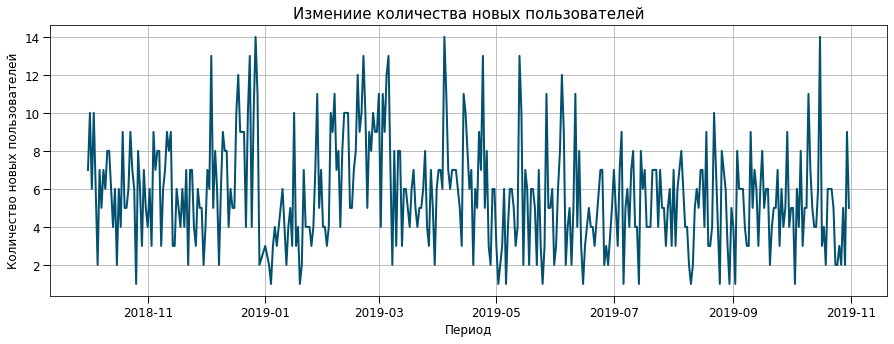

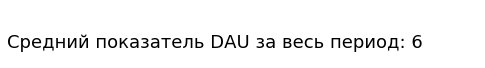

In [ ]:
user_activity(dau_total, 'order_date', 'DAU')

В среднем, в онлайн магазин приходят 6 новых пользователей.  
Динамика скачкообразная.
Поднимемся до недели.

**Изменение количества новых пользователей в неделю**

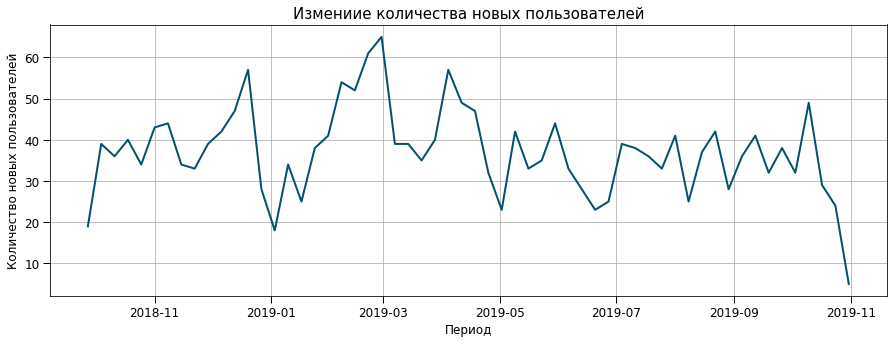

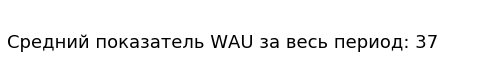

In [ ]:
user_activity(wau_total, 'week_of_order', 'WAU')

В неделю появляется 37 новых пользователей, отмечается периоды изменения новых пользователей:
- рост с ноября по декабрь 2018г.;
- далее спад до нового года, что вполне объяснимо
- рост с января по март 2019 г.

**Изменение количества новых пользователей в месяц**

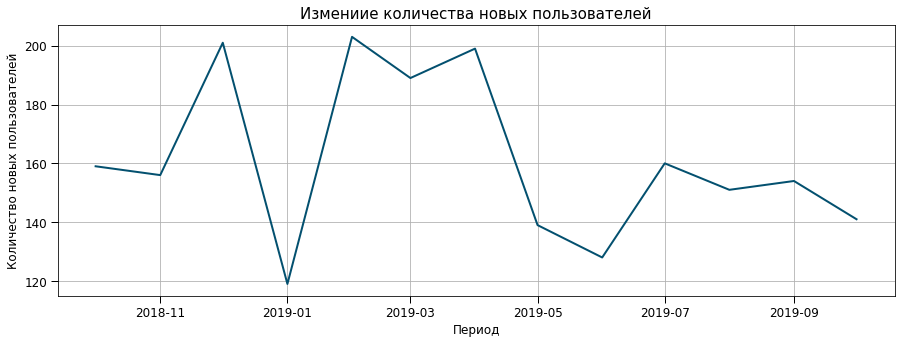

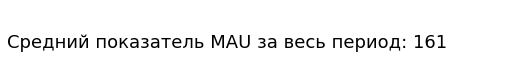

In [ ]:
user_activity(mau_total, 'month_of_order', 'MAU')

В среднем, в месяц приходят 161 новых клиентов.  
На это графике уже видно, что рост новых клиентов начинается с января до февраля 2019 г., высокая отмека удерживается до апреля 2019 г. Далее спад.  
Этот период совпадает с периодом роста спроса, таким образом мы подтвердили сезонность покупок.  

Проверим степень вовлеченности наших пользователей:определим отношение уникальных пользователей в течении дня, к числу уникальных пользователей в течении недели и месяца.

In [ ]:
print('\033[1m' +'Sticky Factor за неделю: ' + '\033[0m' + '{:.0%}'.format(dau_total['customer_id'].mean() / wau_total['customer_id'].mean()))
print('\033[1m' +'Sticky Factor за месяц: ' + '\033[0m' + '{:.0%}'.format(dau_total['customer_id'].mean() / mau_total['customer_id'].mean()))

Sticky Factor за неделю: 15%
Sticky Factor за месяц: 4%


Степень вовлеченность пользователей составляет 4%, это очень низкий показатель.  Необходимо изменить стратегию привленчения новых пользователей. 

#### Вывод
***
Итого отмечается **прирост новых пользователей в период с января по май 2019 г.**  
**Степень вовлеченности очень низкая - 4%.** Это значит, что ежедневно в сервисом пользовалось в среднем 6 человек, всего за месяц приложением воспользовались 16 уникальных пользователей.
Это говорит о том, что пользователи не задерживаются в приложении, вероятно его удержание очень низкое и в нем отсутствует пользовательская база, которая необходима для того, чтобы генерировать доход приложения.
     


<a id='category'></a>
## Категоризация товаров
***

Определим количество уникальных позиций

In [ ]:
print('\033[1m' + 'Количество уникального товара: ' + '\033[0m' + '{}'.format(len(df_filtered['product'].unique())))

Количество уникального товара: 2063


Итого 2063 уникальных позиции.  
Это большое количество чтобы обработать каждую вручную.

**Выработаем стратегию категоризации товаров:**
***
1. Разделим названиие товара на отдельные слова;
2. Выделим первое слово и запишем его в отдельное поле.  
Будем считать его за будущую категорию;
3. Далее укрепним категории по принципу:
    - Категории с самым большим количеством покупателей переберем руками
    - Остальным категориям присвоим категорию "Другое".

In [ ]:
# Разбивка наименования товара по словам
df_filtered['split_name_product'] = df_filtered['product'].str.split()

In [ ]:
# Проускаем каждую строку через цикл, чтобы взять только первое слово наименоваия товара.
list_first_word = []
for i in range(len(df_filtered)):
    list_first_word.append(df_filtered['split_name_product'][i][0])

In [ ]:
# Сохраняем полученное слово в отдельный столбец датасета
df_filtered['first_word_product'] = list_first_word
df_filtered.head()

,index,date,customer_id,order_id,product,quantity,price,order_date,week_of_order,month_of_order,revenue,split_name_product,first_word_product
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,2018-09-27,2018-10-01,142.0,"[Комнатное, растение, в, горшке, Алое, Вера,, ...",Комнатное
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,2018-09-27,2018-10-01,194.0,"[Комнатное, растение, в, горшке, Кофе, Арабика...",Комнатное
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018-09-27,2018-10-01,112.0,"[Радермахера, d-12, см, h-20, см]",Радермахера
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,2018-09-27,2018-10-01,179.0,"[Хризолидокарпус, Лутесценс, d-9, см]",Хризолидокарпус
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,2018-09-27,2018-10-01,112.0,"[Циперус, Зумула, d-12, см, h-25, см]",Циперус


Отлично, наши  предварительные категории готовы.  
Теперь укрепним их.

In [ ]:
# Сводная для подсчета количества товара по каждой категории
group_category = df_filtered.groupby('first_word_product')['customer_id'].count().reset_index().sort_values(by='customer_id', ascending=False)


In [ ]:
print('\033[1m' + 'Всего было продано товара: ' + '\033[0m' + '{}'.format(group_category['customer_id'].sum()))
print('\033[1m' + 'Доля топ-30 по количеству: ' + '\033[0m' + '{:.0%}'.format(group_category['customer_id'].head(100).sum()/group_category ['customer_id'].sum()))

Всего было продано товара: 4231
Доля топ-30 по количеству: 86%


Итого, если мы берем руками 100 категорий, то мы закроем 86% проданных товаров.  
За дело!

In [ ]:
group_category['first_word_product'].head(100)

236            Пеларгония
278               Рассада
335               Сушилка
334         Сумка-тележка
242               Петуния
416                томата
197                 Муляж
69             Гладильная
62                 Герань
341               Тележка
127                Коврик
394                 Чехол
403                 Штора
224            Однолетнее
339                   Таз
281                  Роза
110            Калибрахоа
141               Корзина
105         Искусственный
203                 Набор
305              Скатерть
24                 Бакопа
327             Стремянка
259                 Полки
49                Вешалка
392                Чайник
289              Салатник
371                Фуксия
202                  Мята
380                Цветок
340               Тарелка
27                  Банка
248             Подвесное
368                 Флокс
263               Примула
78              Декабрист
383              Цикламен
214            Новогоднее
22          

Объединим товар в общие категории.  
Названия категорий будем брать из контекста наименования товара.

In [ ]:
# Кухонные приборы
list_kitchen = ['Салатник', 
'Чайник', 
'Тарелка', 
'Контейнер', 
'Кружка', 
'Нож', 
'Сковорода', 
'Ложка', 
'Термокружка', 
'Кувшин', 
'Кастрюля', 
'Вилка', 
'Салфетка',
'Блюдо',
'Стакан'
]

# Декор
list_decor = ['Муляж', 
'Коврик', 
'Штора', 
'Искусственный', 
'Скатерть', 
'Подвесное', 
'Полки', 
'Карниз', 
'Искусственная', 
'Новогоднее',
'Декоративная',
'Ковер',
'Этажерка'
]

# Товары для дома
list_household  = ['Сумка-тележка', 
'Сушилка', 
'Гладильная', 
'Тележка', 
'Чехол', 
'Таз', 
'Однолетнее', 
'Набор', 
'Корзина', 
'Вешалка', 
'Банка', 
'Щетка', 
'Сумка', 
'Лестница-стремянка', 
'Швабра', 
'Подкладка', 
'Подрукавник', 
'Сиденье', 
'Колокольчик',
'Подставка',
'Весы',
'Шнур',
'Махровое',
'Комплект'
]

# Садовые растения и саженцы
list_plants = ['Рассада', 
'Пеларгония', 
'Петуния', 
'томата', 
'Герань', 
'Калибрахоа', 
'Бакопа', 
'Роза', 
'Вербена', 
'Дыня', 
'Лобелия', 
'Базилик', 
'Мята', 
'Эвкалипт', 
'Декабрист', 
'Фуксия', 
'Цветок', 
'Флокс', 
'Цикламен', 
'Фиалка', 
'Примула', 
'Бегония', 
'Циперус', 
'Газания', 
'Капуста', 
'Пуансеттия', 
'Комнатное', 
'Виола', 
'Бальзамин',  
'Антуриум',  
'Алиссум', 
'Хлорофитум', 
'Хризантема',
'Лаванда',
'Космея',
'Томат',
'Мирт',
'Львиный',
'Розмарин',
'Седум'
]

Напишем функцию, которая будет присваивать категорию в зависимости от того в какой лист попадет наш товар.

In [ ]:
def category (product):
    '''
    Фукнция для присваивания категории товара
    На вход принимается первое слово из названия товара 
    ''' 

    if (product in list_plants):
        return 'plants'
    if (product in list_kitchen):
        return 'kitchen'
    if (product in list_decor):
        return 'decor'
    if (product in list_household):
        return 'household'
    return 'other'

In [ ]:
df_filtered['category'] = df_filtered['first_word_product'].apply(category)
df_filtered.sample(5)

,index,date,customer_id,order_id,product,quantity,price,order_date,week_of_order,month_of_order,revenue,split_name_product,first_word_product,category
50,66,2018-10-03 10:00:00,d0c6d3d9-dc3b-4406-afb7-f6cb0da3a4a9,68515,Коврик придверный 45х75см. с рельефным рисунко...,1,674.0,2018-10-03,2018-09-27,2018-10-01,674.0,"[Коврик, придверный, 45х75см., с, рельефным, р...",Коврик,decor
1657,2245,2019-03-07 13:00:00,b4d0da2e-e1c7-4470-922f-d7f9632aee0f,70653,Тележка багажная DELTA ТБР-20 черный с серым г...,1,727.0,2019-03-07,2019-03-07,2019-03-01,727.0,"[Тележка, багажная, DELTA, ТБР-20, черный, с, ...",Тележка,household
1279,1740,2019-02-08 12:00:00,375eeafe-2616-4b2d-ad0c-387ecee9589e,70165,Пеларгония розебудная Queen Ingrid укорененный...,1,134.0,2019-02-08,2019-02-07,2019-02-01,134.0,"[Пеларгония, розебудная, Queen, Ingrid, укорен...",Пеларгония,plants
4120,6590,2019-10-12 09:00:00,d90fe616-af94-485d-8de8-4b94df1fa685,72940,Пеларгония розебудная Apple Blossom укорененны...,1,149.0,2019-10-12,2019-10-10,2019-10-01,149.0,"[Пеларгония, розебудная, Apple, Blossom, укоре...",Пеларгония,plants
365,455,2018-10-27 17:00:00,d396d8ba-7609-48f1-871c-320ca0508271,68773,Цветок искусственный Нарцисс одиночный в ассор...,2,22.0,2018-10-27,2018-10-25,2018-10-01,44.0,"[Цветок, искусственный, Нарцисс, одиночный, в,...",Цветок,plants


Успех! 
Мы завершили категорицию товара.  
Удалим ненужные столбцы, которые были созданы для категоризации товара.

In [ ]:
df_filtered = df_filtered.drop(['split_name_product', 'first_word_product'], 1)

In [ ]:
df_filtered.columns

Index(['index', 'date', 'customer_id', 'order_id', 'product', 'quantity',
       'price', 'order_date', 'week_of_order', 'month_of_order', 'revenue',
       'category'],
      dtype='object')

<a id='segmentation'></a>
## Сегментация пользователей по профилю потребления
***
**To do:**
1. Создать новый признак: пользователь, у которого более 1 уникальной категории.
2. Определить востребованную категорию пользователя;
3. Определить второстепенную категорию пользователя;
4. Определить количество кластеров для сегментации пользователей.
5. Запустить алгоритм кластеризации данных.

Найдем пользователей, у которых более 1 уникальной категории.  

In [ ]:
total_feature_in_category  = df_filtered.groupby(['customer_id','category']).agg({'quantity':'sum','revenue':'sum'}).reset_index()

In [ ]:
# Считаем количество категорий по каждому пользователю
count_category  = df_filtered.groupby('customer_id').agg({'category':'nunique'}).reset_index()

# Оставляем только тех пользователей, у которых больше 1 категории
many_category = count_category[count_category['category'] > 1].reset_index()
many_category = many_category.rename(columns={'category':'n_category'})
many_category = many_category.drop(['index'], 1)
many_category.head()

,customer_id,n_category
0,0184f535-b60a-4914-a982-231e3f615206,2
1,01bd5b9a-2b4e-483c-95a3-40b040c392e8,2
2,0a8362cf-e2d8-4ffc-8072-33239f5e450a,2
3,0f47231c-3a68-404a-88f7-08a4a172c17f,2
4,13f31376-e99b-4a4a-a538-8a5dc64f6599,2


Присвоим признак: есть-ли у пользователя более 1 категории или нет.  
Для этого напишем функцию и примением ее к нашему датасету с пользователями

In [ ]:
def more_category (customer_id):
    '''
    Фукнция для присваивания признака есть у пользователя категория или нет
    На вход принимается id пользователя 
    ''' 

    if customer_id in list(many_category['customer_id']):
        return 1
    return 0

In [ ]:
total_feature_in_category['more_category'] = total_feature_in_category['customer_id'].apply(more_category)

Определим:
- **Самую любимую категорию** - это максимальное значение по количеству покупаемого товара и выручки для каждого пользователя.
- **Вторую сопутствующую категорию** - для пользователей с двумя и более категориями, посчитаем минимальное значение по количеству и выручке.

Определим самую топовую для пользователя категорию и второстепенную.  
Для пользователей, у которых всего 1 категория, эти значения будут равны.

In [ ]:
# Определяем топовую категорию для пользователя
max_in_category = total_feature_in_category.groupby('customer_id').agg({'quantity':'max','revenue':'max'}).reset_index()
max_in_category.columns = ['customer_id', 'max_quantity','max_revenue']

# Определяем второстепенную категорию для пользователя
min_in_category = total_feature_in_category.groupby('customer_id').agg({'quantity':'min','revenue':'min'}).reset_index()
min_in_category.columns = ['customer_id', 'min_quantity','min_revenue']

Отлично, мы получили связку **пользователь и его максимальное и минимальное значение показателей**.  
Теперь определим:
- топовую позицию - фильтр по максимальным значениям:
- второстепенную - фильтр по минимальным значенияи

In [ ]:
# Создаем новый датасет с топовой категорией
top_сategory =  pd.merge(max_in_category,
                         total_feature_in_category,
                         left_on=['customer_id','max_quantity','max_revenue'],
                         right_on=['customer_id','quantity','revenue'],
                         how='left')



In [ ]:
# Создаем новый датасет со второстепенной категорией
lower_сategory =  pd.merge(min_in_category,
                           total_feature_in_category,
                           left_on=['customer_id','min_quantity','min_revenue'],
                           right_on=['customer_id','quantity','revenue'],
                           how='left')

Проверим как выполнено присоединение

In [ ]:
top_сategory.isnull().sum()

customer_id       0
max_quantity      0
max_revenue       0
category         15
quantity         15
revenue          15
more_category    15
dtype: int64

In [ ]:
lower_сategory.isnull().sum()

customer_id       0
min_quantity      0
min_revenue       0
category         20
quantity         20
revenue          20
more_category    20
dtype: int64

Есть пропуски, подготовим датасеты:
- удалим пропуски и лишние поля;
- переименуем названия полей;
- приведем тип данных

Это нужно для проведения алгоритма стандартизации.

In [ ]:
top_сategory = top_сategory.dropna(how = 'any')
top_сategory = top_сategory.drop(['max_quantity', 'quantity', 'revenue', 'max_revenue'], 1)
top_сategory = top_сategory.rename(columns={'category':'top_category'})
top_сategory.head()

,customer_id,top_category,more_category
0,000d6849-084e-4d9f-ac03-37174eaf60c4,plants,0.0
1,001cee7f-0b29-4716-b202-0042213ab038,household,0.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,other,0.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,household,0.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,other,0.0


In [ ]:
lower_сategory = lower_сategory.dropna(how = 'any')
lower_сategory = lower_сategory.drop(['min_quantity', 'quantity', 'revenue', 'min_revenue', 'more_category'], 1)
lower_сategory = lower_сategory.rename(columns={'category':'lower_category'})
lower_сategory.head()


,customer_id,lower_category
0,000d6849-084e-4d9f-ac03-37174eaf60c4,plants
1,001cee7f-0b29-4716-b202-0042213ab038,household
2,00299f34-5385-4d13-9aea-c80b81658e1b,other
3,002d4d3a-4a59-406b-86ec-c3314357e498,household
4,003bbd39-0000-41ff-b7f9-2ddaec152037,other


Топовые и второстепенные категории готовы

Сделаем копию датасета с пользователями для того, чтобы стандартизировать данные и получить по ним кластеры.  
Далее посчитаем средний чек.

In [ ]:
# Делаем копию датасета с пользователями
aggregate_by_users = orders_вy_users.copy()

# Определяем средний чек
aggregate_by_users['average_check'] = aggregate_by_users['total_revenue'] / aggregate_by_users['n_orders']
aggregate_by_users.head()

,customer_id,n_orders,total_quantity,total_revenue,n_products,average_check
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,4,555.0,4,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,442.0,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2,914.0,1,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1649.0,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2,2324.0,1,2324.0


Подтянем нашу топовую категорию и признак что у пользователя более 1 категории

In [ ]:
aggregate_by_users = aggregate_by_users.merge(top_сategory,
                                              on='customer_id',
                                              how='left',
                                              )

Проверим пропущенные значения, которые могу возникнуть при присоединении

In [ ]:
aggregate_by_users.isnull().sum()

customer_id       0
n_orders          0
total_quantity    0
total_revenue     0
n_products        0
average_check     0
top_category      9
more_category     9
dtype: int64

Удалим пропущенные значения, поле c id пользователя отправим в индекс

In [ ]:
aggregate_by_users = aggregate_by_users.dropna(how = 'any')
aggregate_by_users = aggregate_by_users.set_index(['customer_id'])
aggregate_by_users['more_category'] = aggregate_by_users['more_category'].astype(np.int64)

Переведем наши категориальные признаки в бинарное значение.  
Это необходимо для стандартизации.

In [ ]:
aggregate_by_users = pd.get_dummies(aggregate_by_users)
aggregate_by_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1736 entries, 000d6849-084e-4d9f-ac03-37174eaf60c4 to ffe82299-3f5b-4214-87fe-3d36ecccfac3
Data columns (total 11 columns):
n_orders                  1736 non-null int64
total_quantity            1736 non-null int64
total_revenue             1736 non-null float64
n_products                1736 non-null int64
average_check             1736 non-null float64
more_category             1736 non-null int64
top_category_decor        1736 non-null uint8
top_category_household    1736 non-null uint8
top_category_kitchen      1736 non-null uint8
top_category_other        1736 non-null uint8
top_category_plants       1736 non-null uint8
dtypes: float64(2), int64(4), uint8(5)
memory usage: 103.4+ KB


In [ ]:
# обязательная стандартизация данных перед работой с алгоритмами
scaler = StandardScaler()
x_sc = scaler.fit_transform(aggregate_by_users)

# Создание таблицы связок между объектами
linked = linkage(x_sc, method='ward')

Визуализируем количество кластеров, которое определил алгоритм

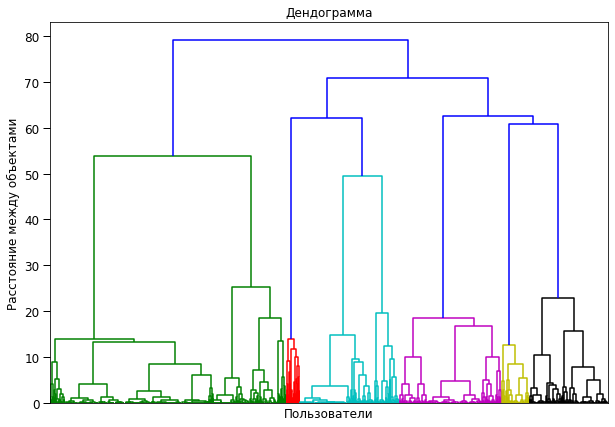

In [ ]:
# Визуализация дендограммы
plt.figure(figsize=(10, 7))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Дендограмма', fontsize=12)
plt.xlabel('Пользователи', fontsize=12)
plt.ylabel('Расстояние между объектами', fontsize=12)
plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)

plt.show() 

Итого мы долны разложить наших пользователей на 6 кластеров.  
Проведем кластеризацию.

**Обучим модель кластеризации на основании алгоритма K-Means**

In [ ]:
# Задаём число кластеров, равное 6
km = KMeans(n_clusters = 6, random_state=0)

# Применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(x_sc)

In [ ]:
# Добавляем кластеры к датасету с пользователями
aggregate_by_users['cluster_km'] = labels

Посмотрим распределение наших пользователй по кластерам

In [ ]:
aggregate_by_users['cluster_km'].value_counts()

2    708
4    339
5    266
1    255
3     84
0     84
Name: cluster_km, dtype: int64

Распределение пользователей по группам не равномерное: какие-то группы маленькие, какие-то большие.  
В этом нет отклонений, так как ранее мы выяснили, что есть пользователи которые приносят больше выручки, имеют большое количество заказов и объем заказов, таких мало.

Перейдем к более детальному анализу сегментов пользователей.

<a id='segment_analysis'></a>
## Анализ сегментов пользователей
***
**To do:**
1. Подтянуть второстепенную категорию;
2. Определить товар для:
    - топовой категории;
    - второстепенной категории.
4. Сделать выводы

In [ ]:
aggregate_by_users = aggregate_by_users.merge(lower_сategory,
                                              on='customer_id',
                                              how='left')

Теперь нам необхоимо определить товар, для топовой категории и товар для второстепенной. Для этого напишем 2 функции:
1. Будет показывать топ-10 востребованного товара;
2. Бюудет показывать топ-10 не востребованного товара.

In [ ]:
def top_products(category):
    '''
    Фукнция для определения топ-10 всотребованного товара категории
    На вход принимается категория, по которой считается количество покупаемых позиций
    ''' 

    print(' ')
    print('\033[1m' + 'Самый востребованный товар категории: ' + '\033[0m' + category)
    print('--------------------------------------------------------------------------------')
    print(
        
        df_filtered[df_filtered['category'] == category]\
        .groupby('product')['product'].count()
        .sort_values(ascending=False).head(10).index
        )


Запустим фукнцию в цикле

In [ ]:
for category in (list(df_filtered['category'].unique())):
    top_products(category)

 
Самый востребованный товар категории: plants
--------------------------------------------------------------------------------
Index(['Пеларгония розебудная Red Pandora укорененный черенок',
       'Пеларгония розебудная Prins Nikolai укорененный черенок',
       'Пеларгония зональная диам. 12 см сиреневый полумахровый',
       'Пеларгония розебудная Mary укорененный черенок',
       'Пеларгония розебудная Queen Ingrid укорененный черенок',
       'Пеларгония розебудная Margaretha укорененный черенок',
       'Пеларгония зональная диам. 12 см коралловая полумахровая',
       'Пеларгония зональная махровая лососевая',
       'Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок',
       'Пеларгония зональная диам. 12 см темнорозовая полумахровая'],
      dtype='object', name='product')
 
Самый востребованный товар категории: other
--------------------------------------------------------------------------------
Index(['Корыто оцинкованное 45 л бесшовное, 1303007',
       '

Отлично, позиции получены.  
Теперь не популярный товар

In [ ]:
def lower_products(category):
    '''
    Фукнция для определения топ-10 второстепенного товара категории
    На вход принимается категория, по которой считается количество покупаемых позиций
    ''' 

    print(' ')
    print('\033[1m' + 'Не популярный товар категории: ' + '\033[0m' + category)
    print('--------------------------------------------------------------------------------')
    print(
        df_filtered[df_filtered['category'] == category]\
        .groupby('product')['product'].count()
        .sort_values(ascending=True).head(10).index
        )


In [ ]:
for category in (list(df_filtered['category'].unique())):
    lower_products(category)

 
Не популярный товар категории: plants
--------------------------------------------------------------------------------
Index(['Рассада Огурца сорт Есаул, кассета по 6шт',
       'Примула комнатная акаулис белая D10 см',
       'Примула комнатная D9 см цвет фуксии',
       'Примула комнатная D9 см фиолетовая', 'Примула комнатная D9 см розовая',
       'Роза садовая плетистая в горшке Шванензее',
       'Примула комнатная D9 см красная',
       'Примула желтая с оранжевым в горшке d-10 см',
       'Примула акаулис Микс d-10 см',
       'Петуния рассада смесь цветов 8-10 листов красная'],
      dtype='object', name='product')
 
Не популярный товар категории: other
--------------------------------------------------------------------------------
Index(['Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759',
       'Ранункулус Клуни Ханои 45 см Нидерланды 10 штук в упаковке',
       'Разделочная доска Классика О-35 35х21х1,5 см',
       'Разделочная доска WEBBER РД-00055 из бамбука 33х24х1 см

In [ ]:
aggregate_by_users.groupby('cluster_km').mean().round(2).T

cluster_km,0,1,2,3,4,5
n_orders,1.00,1.00,1.00,1.00,1.00,1.00
total_quantity,1.79,1.56,1.17,4.62,1.46,1.70
total_revenue,542.46,867.34,1108.41,902.21,692.23,290.96
n_products,1.02,1.03,1.02,4.30,1.03,1.27
average_check,542.46,867.34,1108.41,902.21,692.23,290.96
more_category,0.00,0.00,0.00,0.46,0.00,0.00
top_category_decor,0.00,1.00,0.00,0.05,0.00,0.00
top_category_household,0.00,0.00,1.00,0.10,0.00,0.00
top_category_kitchen,1.00,0.00,0.00,0.01,0.00,0.00
top_category_other,0.00,0.00,0.00,0.13,1.00,0.00


### Вывод
***
Мы произвели сегментацию пользователей и получили 6 групп, разделенных по нескольким параметрам.   
В результате можно сделать следующие выводы:
1. Все группы в среднем делают 1 заказ 
2. Каждая из групп пользователей разделены по наиболее востребованной покупаемой категори категории:
    - Группа **0** - Хозяйственные товары;
    - Группа **1** - покупка товаров в категории "Другие";
    - Группа **2** - Декор;
    - Группа **3** - покупала разные категории, преимущестенно "Садовые растения и саженцы"
    - Группа **4** - Садовые растения и саженцы
    - Группа **5** - Кухонные приборы.
2. По объему покупаемого товара и ассортименту **группы 0,1,2,4,5** практически ни чем не отличаются: в среднем покупают 1.5 товара, с 1 позицией в заказе. Пользовтаели **группы 3** покупают больше всего товара, в среднем 4.6 c широким ассортиментов внутри заказов - 4.3 позиции. Пользователи этой группы также покупают товары других категорий.
3. Пользователи **в группе 0** имеют самый большой чек **средний чек 1108 у.е.** а пользователи **группы 4** самый маленький - **290 у.е.**  
Это говорит о том, что пользователи группы 0 покупают более дорогостоящие товары, а группа 4 нет. Исходя из этого мы можем сделать вывод, о том что категория "Товары для дома" самая дорогостоющая и приносит больше всего выручки, а группа "Садовые растения и саженцы" самая дешевая, и соответственно приносит меньше всего выручки.
4. Самые [востребованные товары](#top_products) для каждой группы пользователей
5. [Товары второстепенной категории](#lower_products), которые необходимо рекламировать пользователям.

<a id='hypothesis_testing'></a>
## Проверка гипотез
***

Перед нами стоит задача проверить гипотезу:  
- **H0**: Средний чек пользователей двух разных категорий не различается;
- **H1**: Средний чек пользователей двух разных категорий различается.

По каждому кластеру вынесем id пользователя и средний чек в отдельные датасеты

In [ ]:
# Срединй чек группы 0
cluster_0 = aggregate_by_users[aggregate_by_users['cluster_km'] ==0] [['customer_id','average_check']]
cluster_0 = cluster_0.reset_index(drop=True)

# Срединй чек группы 1
cluster_1 = aggregate_by_users[aggregate_by_users['cluster_km'] ==1] [['customer_id','average_check']]
cluster_1 = cluster_1.reset_index(drop=True)

# Срединй чек группы 2
cluster_2 = aggregate_by_users[aggregate_by_users['cluster_km'] ==2] [['customer_id','average_check']]
cluster_2 = cluster_2.reset_index(drop=True)

# Срединй чек группы 3
cluster_3 = aggregate_by_users[aggregate_by_users['cluster_km'] ==3] [['customer_id','average_check']]
cluster_3 = cluster_3.reset_index(drop=True)

# Срединй чек группы 4
cluster_4 = aggregate_by_users[aggregate_by_users['cluster_km'] ==4] [['customer_id','average_check']]
cluster_4 = cluster_4.reset_index(drop=True)

# Срединй чек группы 5
cluster_5 = aggregate_by_users[aggregate_by_users['cluster_km'] ==5] [['customer_id','average_check']]
cluster_5 = cluster_5.reset_index(drop=True)


Прежде чем производить тест на проверку гипотез, проверим на гомогенность дисперсий через "Тест Левена".  
Это необходимо для правильного выбора теста и корректности дальнейших результатов.

In [ ]:
print( '\033[1m' + 'Тест на гомогенность дисперсий групп' + '\033[0m')
print('--------------------------------------------------------------------')
levene(cluster_0['average_check'],
       cluster_1['average_check'],
       cluster_2['average_check'],
       cluster_3['average_check'],
       cluster_4['average_check'],
       cluster_5['average_check']
       )


Тест на гомогенность дисперсий групп
--------------------------------------------------------------------


LeveneResult(statistic=26.89564050553974, pvalue=2.866928857829513e-26)

Pvalue < 0.05 говорит нам о том, что дисперсии групп значимо отличаются.  
Таким образом, мы будем проводить статистический тест манна уитни.    Преимущество его состоит в том, что мы отказываемся от предположения одинаковых дисперсий.

**Проверка статистической значимости различий в группах**    
**"Группы 0" c остальными группами**

In [ ]:
data_zero = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5]
name_zero = ['Группа 1', 'Группа 2', 'Группа 3', 'Группа 4', 'Группа 5']
for i,j in zip (data_zero, name_zero):
    print('P-уровень значимости различий среднего чека в: ' + '\033[1m' + 'Группа 0 и ' + j + '\033[0m' + ': {0:.5f}'\
          .format(st.mannwhitneyu(cluster_0['average_check'],
                                  i['average_check'],
                                  alternative = 'two-sided',
                                  ) [1]
                  )
          )

P-уровень значимости различий среднего чека в: Группа 0 и Группа 1: 0.01129
P-уровень значимости различий среднего чека в: Группа 0 и Группа 2: 0.00000
P-уровень значимости различий среднего чека в: Группа 0 и Группа 3: 0.00000
P-уровень значимости различий среднего чека в: Группа 0 и Группа 4: 0.57731
P-уровень значимости различий среднего чека в: Группа 0 и Группа 5: 0.00001


С учетом поравки Бонферрони, мы снижаем **уровень значимости** до 0.05/5 = **0,01**.  
Таким образом, тест показал, что
- Группа 0 **имеет** статистически значимые различие в среднем чеке с группами 1,2,4,5
- Группа 0 **не имеет** статистически значимые различие в среднем чеке с группой 3


**"Группы 1" с остальными группами**

In [ ]:
data_one = [cluster_2, cluster_3, cluster_4, cluster_5]
name_one = ['Группа 2', 'Группа 3', 'Группа 4', 'Группа 5']
for i,j in zip (data_one, name_one):
    print('P-уровень значимости различий среднего чека в: ' + '\033[1m' + 'Группа 1 и ' + j + '\033[0m' + ': {0:.5f}'\
          .format(st.mannwhitneyu(cluster_1['average_check'],
                                  i['average_check'],
                                  alternative = 'two-sided',
                                  ) [1]
                  )
          )

P-уровень значимости различий среднего чека в: Группа 1 и Группа 2: 0.00000
P-уровень значимости различий среднего чека в: Группа 1 и Группа 3: 0.03991
P-уровень значимости различий среднего чека в: Группа 1 и Группа 4: 0.01274
P-уровень значимости различий среднего чека в: Группа 1 и Группа 5: 0.00000


С учетом поравки Бонферрони, мы снижаем **уровень значимости** до 0.05/4 = **0,0125**.  
Таким образом, тест показал, что
- Группа 1 **имеет** статистически значимые различие в среднем чеке с группами 3,4
- Группа 1 **не имеет** статистически значимые различие в среднем чеке с группой 2,5


**"Группы 2" с остальными группами**

In [ ]:
data_two = [cluster_3, cluster_4, cluster_5]
name_two = ['Группа 3', 'Группа 4', 'Группа 5']
for i,j in zip (data_two, name_two):
    print('P-уровень значимости различий среднего чека в: ' + '\033[1m' + 'Группа 2 и ' + j + '\033[0m' + ': {0:.5f}'\
          .format(st.mannwhitneyu(cluster_2['average_check'],
                                  i['average_check'],
                                  alternative = 'two-sided',
                                  ) [1]
                  )
          )

P-уровень значимости различий среднего чека в: Группа 2 и Группа 3: 0.30090
P-уровень значимости различий среднего чека в: Группа 2 и Группа 4: 0.00000
P-уровень значимости различий среднего чека в: Группа 2 и Группа 5: 0.00000


С учетом поравки Бонферрони, мы снижаем **уровень значимости** до 0.05/3 = **0,016**.  
Тест показал, что группа 2  **имеет** статистически значимые различия в среднем чеке с группами 4,5 и **не имеет** с группой 3

**"Группы 3" с остальными группами**

In [ ]:
data_three = [cluster_4, cluster_5]
name_three = ['Группа 4', 'Группа 5']
for i,j in zip (data_three, name_three):
    print('P-уровень значимости различий среднего чека в: ' + '\033[1m' + 'Группа 3 и ' + j + '\033[0m' + ': {0:.5f}'\
          .format(st.mannwhitneyu(cluster_3['average_check'],
                                  i['average_check'],
                                  alternative = 'two-sided',
                                  ) [1]
                  )
          )

P-уровень значимости различий среднего чека в: Группа 3 и Группа 4: 0.00000
P-уровень значимости различий среднего чека в: Группа 3 и Группа 5: 0.00000


С учетом поравки Бонферрони, мы снижаем **уровень значимости** до 0.05/2 = **0,025**.  
Тест показал, что группа 3  **имеет** статистически значимые различие в среднем чеке с группами 4,5

**"Группы 4" с "Группой 5"**

In [ ]:
print('P-уровень значимости различий среднего чека в: ' + '\033[1m' + 'Группа 4 и Группы 5' + '\033[0m' + ': {0:.5f}'\
      .format(st.mannwhitneyu(cluster_4['average_check'], 
                              cluster_5['average_check'],
                              alternative = 'two-sided'
                              ) [1]
              )
      )

P-уровень значимости различий среднего чека в: Группа 4 и Группы 5: 0.00000


Тест показал, что группа 4  **имеет** статистически значимые различие в среднем чеке с группой 5

### Вывод
***
По результатам проведенного теста на статистическую значимость различий среднего чека в группах можно сделать следующие выводы:
- Группа 0 ни имеет статистически значимых различий с группой 3. По сути это одна группа, которая имеет максимальны срединй чек
- Группы 1,2,5 не имеют статистически значимых различий между друг дргуом.  Пользователи этих групп приносят средню  выручку, и могут находится в одной группе.
- Группа 4 имееет статистически значимые различия совсеми группами. Пользователи этого сегмента приносят наименьшую выручку, что статистичски значимо отличается от отсалбных групп пользователей.

Но, надо не забывать, что у нас есть категории потребления, и объединение в гурппы по вышеуказанной логике будет не уместно.  
Используем полученный результат и сделаем акцент в рекомендациях  на 0,3 и 4 группу.

<a id='fin'></a>
## Общий вывод
***
1. По резульатам проведенного исследования мы определили типичного клиента онлайн магазина  - это пользователи, которые делают 1 заказ, с 1 товарной позицией в его составе, в количестве 1 штука.  
Большая часть клиентов делают один заказ и больше не возвращаются в сервис. Это плохой показатель, над которым обязательно необходимо работать. **Рекомендуется:**
    - Проработать вопрос удобства работы в сервисе, возможно пользователям не понятно как его использовать.
    - Изучить воронку продаж, возможно есть узкие места, например способ добавления товара в корзину.
    - Изучить качество сервиса доставки, работы по сопровождению пользователей;  
2. Оценка пользовательской активности показала, что в среднем за год, в день появляется 6 новых пользователей, в месяц 161. Таким образом коэффициент вовлеченности составил 4%, при среднем коэффициенте по рынку 20%. То есть наш сервис находится в нижней границе.  **Рекомендуется:**
    - Провести мероприятия по изменению стратегии привлечения клиентов.
3. Мы разделили наших покупателей по следующим параметрам:
    - Количество заказов;
    - Объем покупаемого товара;
    - Ширина ассортимента заказов;
    - Покупка товаров других категорий;
    - По потребляемой категории.  

4. В результате мы получили группы пользователей которые отличаются по профилю потребления с перечнем наиболее [востребованных товаров](#top_products):
    - Группа 0 - Хозяйственные товары и товары для дома;
    - Группа 1 - товары категории "Другое";
    - Группа 2 - Декор;
    - Группа 3 - покупала разные категории, преимущестенно "Садовые растения и саженцы";
    - Группа 4 - Садовые растения и саженцы;
    - Группа 5 - Кухонные приборы.
5. По результатам статистического теста на различия среднего чека в группах, мы выяснили:
    - Средний чек в группах 0 и 3 не отличается и имеет самый высокий уровень выручки. Рекомендуется рекламировать товары категории "Хозяйственные товар и товары для дома" . Кроме основных потребляемых товаров, группе 3 рекомендуется предлагать [дополнительные товары](#lower_products) других категорий, так как пользователи этой группы имеют более широкий ассортимент в заказах.
    - Средний чек в группах 1,2,5 не имеет статистически значимых различий и находится на уровне среднего значения всех покупателей.
    - Средний чек в группе 4 имееет статистически значимые различия со значениями остальных групп.  Это группа пользователей покупет товары категории садовые растения и саженцы" и приносит меньше всего выручки.
6. Следует отметить наиболее эффективный период проведения рекламной кампании: с января по май.  
Именно в этот период наблюдается рост количества новых пользователей и  рост объема продаж.



<a id='application'></a>
## Приложение
***

<a id='top_products'></a>
**Востребованный товар**


Категория    | Товар        
-------------| -------------
**plants**   | Пеларгония розебудная Red Pandora укорененный черенок
             | Пеларгония розебудная Prins Nikolai укорененный черенок
             | Пеларгония зональная диам. 12 см сиреневый полумахровый
             | Пеларгония розебудная Mary укорененный черенок
             | Пеларгония розебудная Queen Ingrid укорененный черенок
             | Пеларгония розебудная Margaretha укорененный черенок
             | Пеларгония зональная диам. 12 см коралловая полумахровая
             | Пеларгония зональная махровая лососевая
             | Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок
             | Пеларгония зональная диам. 12 см темнорозовая полумахровая
             |
**household**| Сумка-тележка 2-х колесная Gimi Argo синяя
             | Однолетнее растение Петуния махровая в кассете 4 шт, Россия
             | Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ
             | Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м
             | Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ
             | Сумка-тележка 2-х колесная складная Gimi Flexi зеленая
             | Сушилка для белья потолочная Лиана 2,4 м 1703011
             | Сушилка для белья напольная НИКА СБП1/С 18 м
             | Сушилка для белья потолочная Лиана 2,0 м 1703009
             | Тележка багажная DELTA ТБР-15 цвет в ассортименте грузоподъемность 30 кг РОССИЯ
             |
**decor**    | Новогоднее дерево Ель сербская d-21 см h-60 см
             | Муляж Баклажан 18 см', 'Муляж Зеленое яблоко полиуретан d-6 см
             | Муляж Морковь 16 см
             | Штора для ванной комнаты Quadretto 240х200 см белая, Bacchetta, 4062
             | Муляж Перец Чили в связке, красный, 60 см, полиуретан, Fancy Fair/ff RP60'
             | Полки QWERTY Нью-Йорк правый белый/голубой 44х24х10 см 40х20х10 см 36х16х10 см 72012
             | Коврик хлопковый 40х60 см цвета в ассортименте 6194
             | Муляж Персики мини полиуретан d-6 см
             | Искусственная композиция из цветов пластиковая Ромашка мини розовая
              |
**kitchen**   | Кувшин пластмассовый с крышкой "Кумган" 2,0 л 1408003
              | Нож столовый RIPPLE 80 г 2 шт, Attribute, ACR042
              | Вилка столовая RIPPLE сталь 3 мм, 3 шт, Attribute, ACR013
              | Ложка чайная RIPPLE сталь 2,5 мм, 3 шт, Attribute, ACR033
              | Ложка столовая RIPPLE сталь 3 мм, 3 шт, Attribute, ACR023
              | Салатник Luminarc КУТЮР 27 см H3529
              | Термокружка Alpenkok AK-04010A синий 400 мл
              | Термокружка Яромир КРЕМЛЬ ЯР-2406М 400 мл
              | Вилка столовая 3 предмета Кокос СВК102
              | Контейнер для овощей Полимербыт 3-х секционный лоток 9 л 4312600
              |
**other**     | Блюдо Pasabahce серия Конья диаметр 354 мм 54372B
              | Лаванда в горшке d-15 см
              | Корыто оцинкованное 45 л бесшовное, 1303007
              | Мединилла Магнифика d-17 см h-60 см
              | Окномойка с алюминиевой телескопической ручкой 120 см, щетка 25 см, 57572 1804047
              | Львиный зев рассада однолетних цветов в кассете по 6 шт
              | Измельчитель овощей ручной ШК-4 деревянный, 3 ножа, 1516020
              | Чабер Bolero d-7 см', 'Седум почвопокровный смесь окрасок объем 1 л
              | Рукав для гладильной доски COLOMBO STIRAMANICHE 53Х13 см B138LGPW

<a id='lower_products'></a>
**Второстепенный товар**

Категория    | Товар        
-------------| -------------
**plants**   | Рассада Огурца сорт Даша, кассета по 6шт
             | Примула комнатная акаулис белая D10 см 
             | Примула комнатная D9 см цвет фуксии
             | Примула комнатная D9 см фиолетовая
             | Примула комнатная D9 см розовая
             | Роза садовая парковая в горшке Эден Роуз
             | Примула комнатная D9 см красная
             | Примула желтая с оранжевым в горшке d-10 см
             | Примула комнатная акаулис красная D10 см
             | Примула акаулис Микс d-10 см
             |
**household** | Банка РОНДО ВАЛЕНСИЯ 1л, G8494, Luminarc, Китай
              | Сумка-тележка хозяйственная RolserJet C. Capri Joy фиолетовая, JET017 malva JOY
              | Сумка-тележка хозяйственная Rolser Plegamatic Orbita,Gloriaфиолетовая, PLE055 malva PLEGABLE
              | Сумка-тележка хозяйственная Rolser Paris, бордовая, PEP001 bassi JOY
              | Cумка-тележка хозяйственная Rolser PAR015 mandarina DOS+2 оранжевая
              | Сумка-тележка хозяйственная Rolser MOUNTAIN черная, MOU076 negro CONVERT RG
              | Сумка-тележка хозяйственная Rolser MOU041 malva RD6 сиреневая
              | Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная
              | Сумка-тележка хозяйственная Rolser MNB017 fucsia LOGIC DOS+2 фуксия
              | Сумка-тележка хозяйственная Rolser MNB012 azul Logic RG
              |
**decor**     | Штора текстильная для ванны и душа полиэстер
              | "Разноцветные пузырьки" 180х200см, розов/желт/белый, DSCN4061
              | Муляж Груша мини 2 шт желтая 4 см
              | Муляж Груша мини 2 шт, желтая 4 см
              | Муляж Груша, желтый, 9,5 см, полиуретан, Fancy Fair/ff LI95-01
              | Штора для ванной Spirella / Спирелла TEX Rings, текстиль с гидрофобной пропиткой, серо-черный, 180*200 см, 1015184
              | Штора для ванной Spirella / Спирелла TEX Porto, белый, текстиль с гидрофобной пропиткой, 180*200 см, 1033938
              | Штора для ванной Spirella / Спирелла Peva Hugo, синий, полиэтилен, 180*200 см, 1001951
              | Штора для ванной Spirella / Спирелла Peva BIO, белый, полиэтилен, 180*200 см, 1024106
              | Штора для ванной Spirella / Спирелла FLY, фиолетовый, текстиль, 180*200 см, 1013539
              | Штора для ванной 180х200 см, Rigone Розовый
              |
**kitchen**   | Салатник АСПЕН 18 см H4121 Luminarc
              | Тарелка обеденная АЛЬТО САПФИР 26 см J1749 Luminarc
              | Тарелка десертная ХЕЛЛО КИТТИ СВИТ ПИНК 20 см H5479 Luminarc
              | Тарелка десертная СТОУНМАНИЯ ОРАНЖ 20,5 см H3557 Luminarc
              | Тарелка десертная МОКА БРАУН 19 см H7013 Luminarc
              | Тарелка десертная МАГДА 19 см H8579 Luminarc
              | Тарелка десертная КОТОН ФЛАУЭР 19,5 см H2783 Luminarc
              | Тарелка десертная ИРИС D3700 Luminarc
              | Тарелка десертная Attribute LILY TRACERY WHITE 20 см ADL021
              | Сковорода алюминиевая с керамическим покрытием БЬЯНКА Вок 20 см, TVS, 4L10520
              |
**other**     | Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759
              | Пробка для ванны резиновая с цепочкой 1206157
              | Пробка для ванны резиновая (Д-40 мм) 1206155
              | Прищепки для белья York Spring Prestige, 9603/Z027
              | Пресс для чеснока Attribute WESTERN AGW050
              | Полотенце прессованное P48 Сердце_3, 100% хлопок 278 г/м2, 30х60 см, Wellness, 4607101069088
              | Полотенце прессованное P46 Авто_2, 100% хлопок 278 г/м2, 30х60 см, Wellness, 4607101069064
              | Полотенце махровое Гармония, 100% хлопок 335 г/м2, 32х70 см, Wellness, 4630005362832
              | Полотенце кухонное Мила* mix, 100% хлопок 170 г/м2, 38х63,5 см, цвета в ассортименте, Wellness, 4630005366090
              | Полка для обуви Hausmann 70х27х40 см коричневый HM-3011                              

In [ ]:
# Выгрузка обработанного файла csv для создания дашборда
# df_filtered.to_csv('filtered_order_data', sep=',', encoding='utf-8')